# 第6章补充：偏差-方差分解详解

> **学习目标：**
> - 深入理解偏差（Bias）和方差（Variance）的概念
> - 掌握偏差-方差分解的数学推导
> - 理解欠拟合和过拟合与偏差-方差的关系
> - 了解模型复杂度与泛化误差的权衡
> - 理解Dropout作为集成学习的解释
>
> **前置知识：** 06_regularization.ipynb 的内容
>
> **学习时间：** 2-3小时

---

In [2]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
np.random.seed(42)

# 设置绘图风格
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.sans-serif'] = [
    'Arial Unicode MS',  # macOS通用
    'PingFang SC',       # macOS系统字体
    'STHeiti',           # 华文黑体
    'Heiti TC',          # 黑体-繁
    'SimHei',            # 黑体
]
plt.rcParams['axes.unicode_minus'] = False

print("环境配置完成！")

环境配置完成！


---

## 1. 偏差与方差的直观理解

### 1.1 打靶类比

想象你在射击靶子，每次射击都有一定的随机性：

| 情况 | 偏差 | 方差 | 描述 |
|------|------|------|------|
| 理想 | 低 | 低 | 准确且稳定，射击点集中在靶心 |
| 高偏差 | 高 | 低 | 稳定但不准确，射击点集中但偏离靶心 |
| 高方差 | 低 | 高 | 平均准确但不稳定，射击点分散但围绕靶心 |
| 最糟 | 高 | 高 | 既不准确也不稳定 |

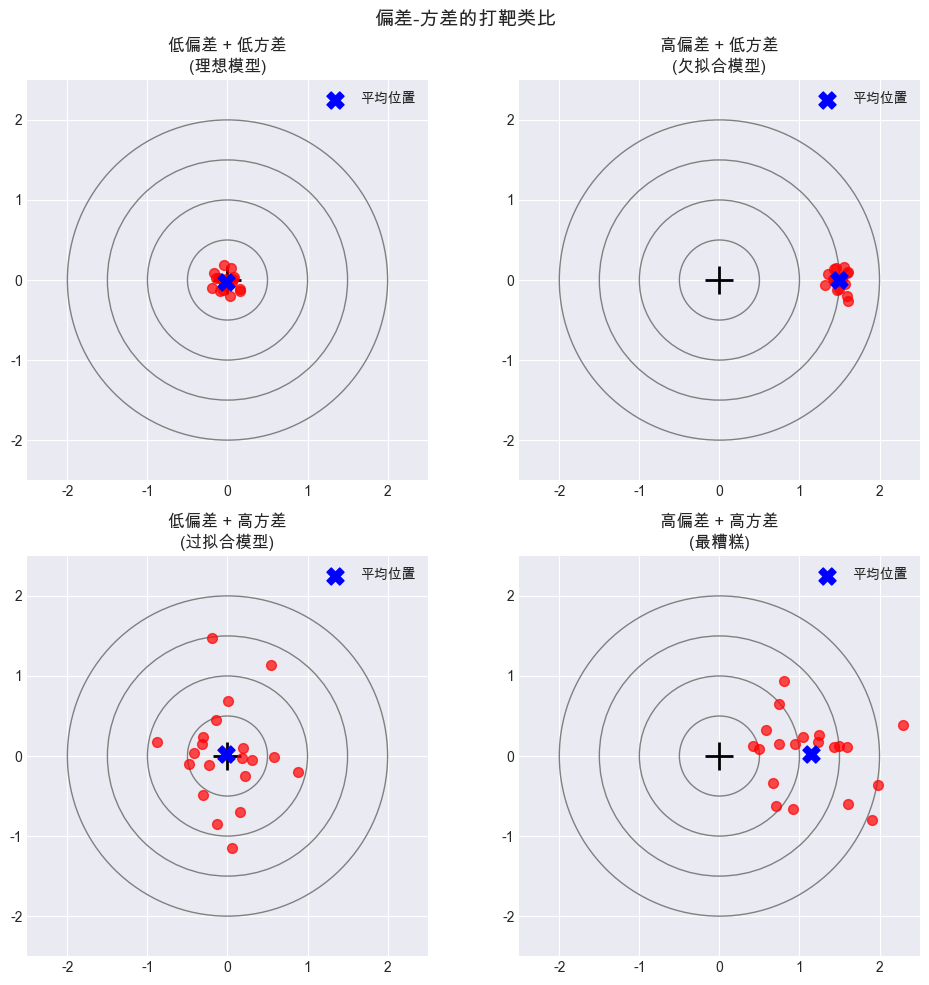

解读：
- 红点：每次预测的结果
- 蓝X：预测的平均值
- 靶心(+)：真实值

- 偏差 = 蓝X到靶心的距离
- 方差 = 红点的分散程度


In [3]:
def visualize_bias_variance_target():
    """
    用打靶图可视化偏差和方差的概念
    
    偏差(Bias): 预测的平均值与真实值的差距
    方差(Variance): 预测值之间的分散程度
    """
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    # 定义四种情况
    cases = [
        {'bias': 0, 'variance': 0.1, 'title': '低偏差 + 低方差\n(理想模型)'},
        {'bias': 1.5, 'variance': 0.1, 'title': '高偏差 + 低方差\n(欠拟合模型)'},
        {'bias': 0, 'variance': 0.6, 'title': '低偏差 + 高方差\n(过拟合模型)'},
        {'bias': 1.2, 'variance': 0.5, 'title': '高偏差 + 高方差\n(最糟糕)'},
    ]
    
    for ax, case in zip(axes.flat, cases):
        # 绘制靶子
        for r in [2, 1.5, 1, 0.5]:
            circle = plt.Circle((0, 0), r, fill=False, color='gray', linewidth=1)
            ax.add_patch(circle)
        
        # 靶心
        ax.plot(0, 0, 'k+', markersize=20, mew=2)
        
        # 生成射击点
        n_shots = 20
        # 偏差：所有点偏离靶心的方向
        bias_x, bias_y = case['bias'], 0
        # 方差：点之间的分散程度
        shots_x = np.random.normal(bias_x, case['variance'], n_shots)
        shots_y = np.random.normal(bias_y, case['variance'], n_shots)
        
        # 绘制射击点
        ax.scatter(shots_x, shots_y, c='red', s=50, alpha=0.7, zorder=5)
        
        # 绘制平均位置
        mean_x, mean_y = np.mean(shots_x), np.mean(shots_y)
        ax.scatter(mean_x, mean_y, c='blue', s=150, marker='X', 
                   label='平均位置', zorder=6)
        
        ax.set_xlim(-2.5, 2.5)
        ax.set_ylim(-2.5, 2.5)
        ax.set_aspect('equal')
        ax.set_title(case['title'], fontsize=12)
        ax.legend(loc='upper right')
    
    plt.suptitle('偏差-方差的打靶类比', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("解读：")
    print("- 红点：每次预测的结果")
    print("- 蓝X：预测的平均值")
    print("- 靶心(+)：真实值")
    print("\n- 偏差 = 蓝X到靶心的距离")
    print("- 方差 = 红点的分散程度")

visualize_bias_variance_target()

### 1.2 正式定义

假设真实的数据生成过程为：
$$y = f(x) + \epsilon$$

其中：
- $f(x)$ 是真实的（未知的）函数
- $\epsilon$ 是噪声，满足 $E[\epsilon] = 0$, $Var(\epsilon) = \sigma^2$

我们训练一个模型 $\hat{f}(x)$ 来近似 $f(x)$。

**偏差（Bias）**：
$$\text{Bias}[\hat{f}(x)] = E[\hat{f}(x)] - f(x)$$

偏差衡量模型预测的**期望值**与真实值的差距。高偏差意味着模型**系统性地偏离**真实值。

**方差（Variance）**：
$$\text{Var}[\hat{f}(x)] = E[(\hat{f}(x) - E[\hat{f}(x)])^2]$$

方差衡量模型预测在不同训练集上的**波动程度**。高方差意味着模型对训练数据**过度敏感**。

---

## 2. 偏差-方差分解

### 2.1 数学推导

对于回归问题，使用均方误差（MSE）作为损失函数：

$$\text{MSE} = E[(y - \hat{f}(x))^2]$$

**完整推导：**

$$\begin{align}
\text{MSE} &= E[(y - \hat{f}(x))^2] \\
&= E[(f(x) + \epsilon - \hat{f}(x))^2] \\
&= E[(f(x) - \hat{f}(x))^2] + E[\epsilon^2] + 2E[(f(x) - \hat{f}(x))\epsilon] \\
&= E[(f(x) - \hat{f}(x))^2] + \sigma^2 \quad (\text{因为} E[\epsilon] = 0)
\end{align}$$

接下来分解第一项。令 $\bar{f} = E[\hat{f}(x)]$：

$$\begin{align}
E[(f(x) - \hat{f}(x))^2] &= E[(f(x) - \bar{f} + \bar{f} - \hat{f}(x))^2] \\
&= E[(f(x) - \bar{f})^2] + E[(\bar{f} - \hat{f}(x))^2] + 2E[(f(x) - \bar{f})(\bar{f} - \hat{f}(x))] \\
&= (f(x) - \bar{f})^2 + E[(\hat{f}(x) - \bar{f})^2] + 0 \\
&= \text{Bias}^2[\hat{f}(x)] + \text{Var}[\hat{f}(x)]
\end{align}$$

**最终结果（偏差-方差分解）：**

$$\boxed{\text{MSE} = \text{Bias}^2 + \text{Variance} + \sigma^2}$$

- **Bias²**: 模型的系统性误差
- **Variance**: 模型对训练数据的敏感度
- **σ²**: 不可约误差（数据本身的噪声）

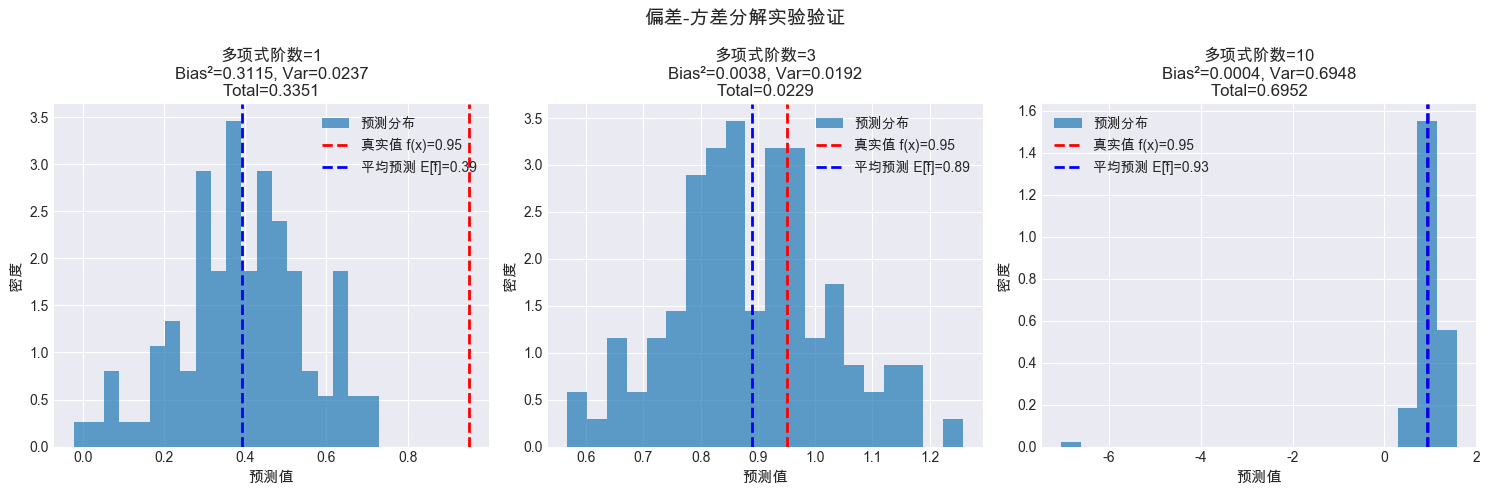


偏差-方差分解结果：
--------------------------------------------------
       模型复杂度 |      Bias² |   Variance |      Total
--------------------------------------------------
    degree=1 |     0.3115 |     0.0237 |     0.3351
    degree=3 |     0.0038 |     0.0192 |     0.0229
   degree=10 |     0.0004 |     0.6948 |     0.6952
--------------------------------------------------

噪声方差 σ² = 0.0900


In [3]:
def demonstrate_bias_variance_decomposition():
    """
    通过实验验证偏差-方差分解
    
    实验设计:
        1. 定义一个真实函数 f(x)
        2. 生成多个带噪声的训练集
        3. 在每个训练集上训练模型
        4. 计算偏差、方差和总误差
    """
    # 真实函数: f(x) = sin(2*pi*x)
    def true_function(x):
        return np.sin(2 * np.pi * x)
    
    # 参数设置
    n_samples = 20         # 每个训练集的样本数
    n_datasets = 100       # 训练集的数量（用于估计期望）
    noise_std = 0.3        # 噪声标准差
    x_test = np.array([0.3])  # 测试点
    
    # 不同复杂度的模型（多项式阶数）
    degrees = [1, 3, 10]
    
    results = {}
    
    for degree in degrees:
        predictions = []
        
        for _ in range(n_datasets):
            # 生成训练数据
            X_train = np.random.uniform(0, 1, n_samples)
            y_train = true_function(X_train) + np.random.normal(0, noise_std, n_samples)
            
            # 训练多项式回归模型
            poly = PolynomialFeatures(degree=degree)
            X_poly = poly.fit_transform(X_train.reshape(-1, 1))
            model = LinearRegression()
            model.fit(X_poly, y_train)
            
            # 在测试点预测
            X_test_poly = poly.transform(x_test.reshape(-1, 1))
            pred = model.predict(X_test_poly)[0]
            predictions.append(pred)
        
        predictions = np.array(predictions)
        
        # 计算偏差和方差
        f_true = true_function(x_test)[0]
        mean_pred = np.mean(predictions)
        
        bias_squared = (mean_pred - f_true) ** 2
        variance = np.var(predictions)
        
        results[degree] = {
            'bias_squared': bias_squared,
            'variance': variance,
            'total': bias_squared + variance,
            'predictions': predictions,
            'mean_pred': mean_pred
        }
    
    # 可视化
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for idx, degree in enumerate(degrees):
        ax = axes[idx]
        r = results[degree]
        
        # 绘制预测分布
        ax.hist(r['predictions'], bins=20, density=True, alpha=0.7, 
                label='预测分布')
        ax.axvline(true_function(x_test)[0], color='red', linestyle='--', 
                   linewidth=2, label=f'真实值 f(x)={true_function(x_test)[0]:.2f}')
        ax.axvline(r['mean_pred'], color='blue', linestyle='--', 
                   linewidth=2, label=f'平均预测 E[f̂]={r["mean_pred"]:.2f}')
        
        ax.set_xlabel('预测值', fontsize=11)
        ax.set_ylabel('密度', fontsize=11)
        ax.set_title(f'多项式阶数={degree}\n'
                     f'Bias²={r["bias_squared"]:.4f}, Var={r["variance"]:.4f}\n'
                     f'Total={r["total"]:.4f}', fontsize=12)
        ax.legend()
    
    plt.suptitle('偏差-方差分解实验验证', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # 打印结果表格
    print("\n偏差-方差分解结果：")
    print("-" * 50)
    print(f"{'模型复杂度':>12} | {'Bias²':>10} | {'Variance':>10} | {'Total':>10}")
    print("-" * 50)
    for degree in degrees:
        r = results[degree]
        print(f"{'degree='+str(degree):>12} | {r['bias_squared']:>10.4f} | {r['variance']:>10.4f} | {r['total']:>10.4f}")
    print("-" * 50)
    print(f"\n噪声方差 σ² = {noise_std**2:.4f}")
    
    return results

results = demonstrate_bias_variance_decomposition()

---

## 3. 偏差-方差权衡

### 3.1 模型复杂度的影响

**简单模型（高偏差、低方差）：**
- 假设过于简化，无法捕捉数据的真实模式
- 在任何训练集上都会产生类似的（错误的）结果
- 典型表现：欠拟合

**复杂模型（低偏差、高方差）：**
- 有足够的容量拟合复杂模式
- 但也容易拟合噪声，导致不同训练集上结果差异大
- 典型表现：过拟合

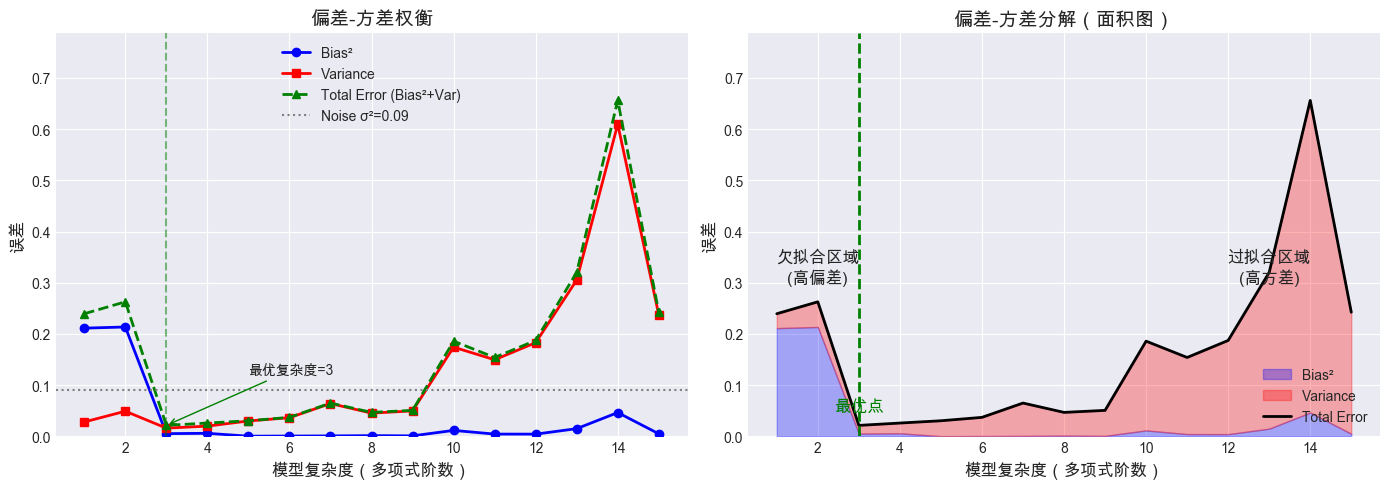


关键观察：
1. 最优模型复杂度 = 3
2. 在最优点：Bias² = 0.0053, Variance = 0.0161
3. 复杂度太低（欠拟合）：高偏差，模型无法捕捉数据的真实模式
4. 复杂度太高（过拟合）：高方差，模型拟合了噪声


In [4]:
def visualize_bias_variance_tradeoff():
    """
    可视化偏差-方差权衡与模型复杂度的关系
    """
    # 真实函数
    def true_function(x):
        return np.sin(2 * np.pi * x)
    
    # 参数
    n_samples = 30
    n_datasets = 50
    noise_std = 0.3
    degrees = range(1, 16)
    
    # 测试点
    x_test = np.linspace(0, 1, 50)
    f_true = true_function(x_test)
    
    bias_squared_list = []
    variance_list = []
    
    for degree in degrees:
        all_predictions = []
        
        for _ in range(n_datasets):
            # 生成训练数据
            X_train = np.random.uniform(0, 1, n_samples)
            y_train = true_function(X_train) + np.random.normal(0, noise_std, n_samples)
            
            # 训练模型
            poly = PolynomialFeatures(degree=degree)
            X_poly = poly.fit_transform(X_train.reshape(-1, 1))
            model = Ridge(alpha=1e-6)  # 添加微小正则化防止数值问题
            model.fit(X_poly, y_train)
            
            # 预测
            X_test_poly = poly.transform(x_test.reshape(-1, 1))
            pred = model.predict(X_test_poly)
            all_predictions.append(pred)
        
        all_predictions = np.array(all_predictions)  # shape: (n_datasets, n_test_points)
        
        # 计算平均偏差平方和平均方差（在所有测试点上）
        mean_pred = np.mean(all_predictions, axis=0)
        bias_squared = np.mean((mean_pred - f_true) ** 2)
        variance = np.mean(np.var(all_predictions, axis=0))
        
        bias_squared_list.append(bias_squared)
        variance_list.append(variance)
    
    # 转换为numpy数组
    bias_squared_arr = np.array(bias_squared_list)
    variance_arr = np.array(variance_list)
    total_error = bias_squared_arr + variance_arr
    
    # 可视化
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 左图：偏差-方差曲线
    ax1 = axes[0]
    ax1.plot(degrees, bias_squared_arr, 'b-', linewidth=2, label='Bias²', marker='o')
    ax1.plot(degrees, variance_arr, 'r-', linewidth=2, label='Variance', marker='s')
    ax1.plot(degrees, total_error, 'g--', linewidth=2, label='Total Error (Bias²+Var)', marker='^')
    ax1.axhline(y=noise_std**2, color='gray', linestyle=':', label=f'Noise σ²={noise_std**2:.2f}')
    
    # 标记最优复杂度
    best_degree = degrees[np.argmin(total_error)]
    ax1.axvline(x=best_degree, color='green', linestyle='--', alpha=0.5)
    ax1.annotate(f'最优复杂度={best_degree}', xy=(best_degree, min(total_error)),
                 xytext=(best_degree + 2, min(total_error) + 0.1),
                 arrowprops=dict(arrowstyle='->', color='green'))
    
    ax1.set_xlabel('模型复杂度（多项式阶数）', fontsize=12)
    ax1.set_ylabel('误差', fontsize=12)
    ax1.set_title('偏差-方差权衡', fontsize=14)
    ax1.legend()
    ax1.set_ylim(0, max(total_error) * 1.2)
    
    # 右图：区域标注
    ax2 = axes[1]
    ax2.fill_between(degrees, 0, bias_squared_arr, alpha=0.3, color='blue', label='Bias²')
    ax2.fill_between(degrees, bias_squared_arr, bias_squared_arr + variance_arr, 
                     alpha=0.3, color='red', label='Variance')
    ax2.plot(degrees, total_error, 'k-', linewidth=2, label='Total Error')
    
    # 添加区域标签
    ax2.annotate('欠拟合区域\n(高偏差)', xy=(2, 0.3), fontsize=12, ha='center')
    ax2.annotate('过拟合区域\n(高方差)', xy=(13, 0.3), fontsize=12, ha='center')
    ax2.axvline(x=best_degree, color='green', linestyle='--', linewidth=2)
    ax2.annotate('最优点', xy=(best_degree, 0.05), fontsize=12, ha='center', color='green')
    
    ax2.set_xlabel('模型复杂度（多项式阶数）', fontsize=12)
    ax2.set_ylabel('误差', fontsize=12)
    ax2.set_title('偏差-方差分解（面积图）', fontsize=14)
    ax2.legend()
    ax2.set_ylim(0, max(total_error) * 1.2)
    
    plt.tight_layout()
    plt.show()
    
    print("\n关键观察：")
    print(f"1. 最优模型复杂度 = {best_degree}")
    print(f"2. 在最优点：Bias² = {bias_squared_arr[best_degree-1]:.4f}, Variance = {variance_arr[best_degree-1]:.4f}")
    print("3. 复杂度太低（欠拟合）：高偏差，模型无法捕捉数据的真实模式")
    print("4. 复杂度太高（过拟合）：高方差，模型拟合了噪声")

visualize_bias_variance_tradeoff()

### 3.2 不同模型的拟合效果

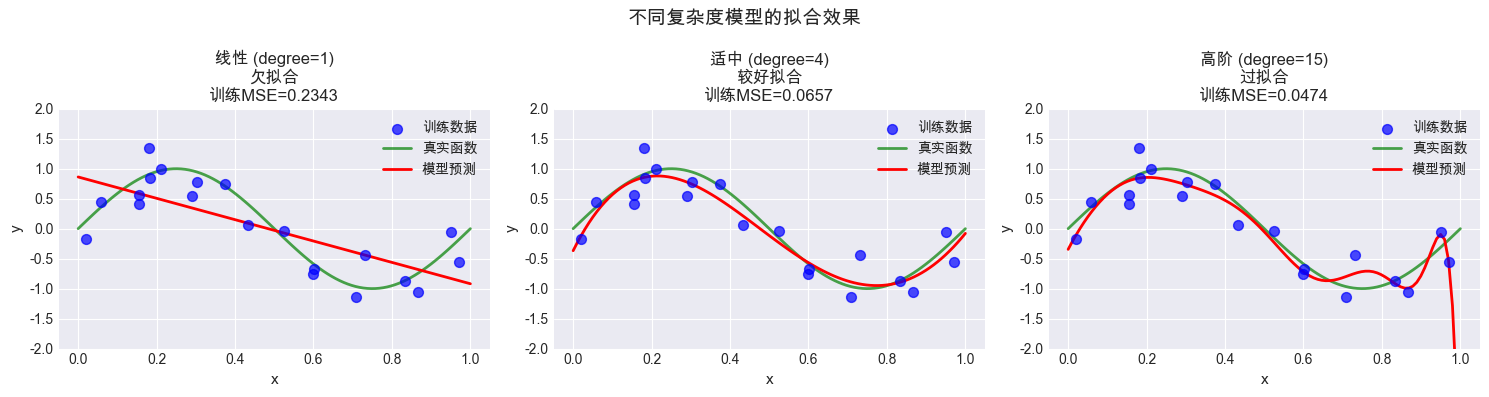

In [5]:
def visualize_fitting_examples():
    """
    可视化不同复杂度模型的拟合效果
    """
    # 真实函数
    def true_function(x):
        return np.sin(2 * np.pi * x)
    
    # 生成数据
    np.random.seed(42)
    n_samples = 20
    noise_std = 0.3
    
    X_train = np.sort(np.random.uniform(0, 1, n_samples))
    y_train = true_function(X_train) + np.random.normal(0, noise_std, n_samples)
    
    X_plot = np.linspace(0, 1, 100)
    y_true = true_function(X_plot)
    
    # 不同复杂度的模型
    models = [
        (1, '线性 (degree=1)\n欠拟合'),
        (4, '适中 (degree=4)\n较好拟合'),
        (15, '高阶 (degree=15)\n过拟合'),
    ]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for ax, (degree, title) in zip(axes, models):
        # 训练模型
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X_train.reshape(-1, 1))
        model = Ridge(alpha=1e-10)
        model.fit(X_poly, y_train)
        
        # 预测
        X_plot_poly = poly.transform(X_plot.reshape(-1, 1))
        y_pred = model.predict(X_plot_poly)
        
        # 绘图
        ax.scatter(X_train, y_train, c='blue', s=50, alpha=0.7, label='训练数据', zorder=5)
        ax.plot(X_plot, y_true, 'g-', linewidth=2, label='真实函数', alpha=0.7)
        ax.plot(X_plot, y_pred, 'r-', linewidth=2, label='模型预测')
        
        # 计算误差
        train_mse = np.mean((model.predict(X_poly) - y_train)**2)
        
        ax.set_xlabel('x', fontsize=11)
        ax.set_ylabel('y', fontsize=11)
        ax.set_title(f'{title}\n训练MSE={train_mse:.4f}', fontsize=12)
        ax.legend(loc='upper right')
        ax.set_ylim(-2, 2)
    
    plt.suptitle('不同复杂度模型的拟合效果', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_fitting_examples()

---

## 4. 减少偏差和方差的方法

### 4.1 减少偏差的方法

| 方法 | 说明 |
|------|------|
| 增加模型复杂度 | 使用更深/更宽的网络 |
| 增加特征 | 添加更多有意义的特征 |
| 减少正则化 | 降低L2系数等 |
| 延长训练时间 | 让模型充分学习 |

### 4.2 减少方差的方法

| 方法 | 说明 |
|------|------|
| 增加训练数据 | 最有效的方法 |
| 正则化 | L1/L2正则化、Dropout等 |
| 早停 | Early Stopping |
| 集成方法 | Bagging、随机森林等 |
| 数据增强 | 人为增加训练样本多样性 |

In [ ]:
def demonstrate_data_size_effect():
    """
    演示训练数据量对偏差和方差的影响
    
    更多的数据 → 更低的方差（模型更稳定）
    """
    def true_function(x):
        return np.sin(2 * np.pi * x)
    
    noise_std = 0.3
    degree = 7  # 固定模型复杂度
    n_datasets = 50
    sample_sizes = [10, 20, 50, 100, 200]
    
    x_test = np.linspace(0, 1, 50)
    f_true = true_function(x_test)
    
    results = {}
    
    for n_samples in sample_sizes:
        all_predictions = []
        
        for _ in range(n_datasets):
            X_train = np.random.uniform(0, 1, n_samples)
            y_train = true_function(X_train) + np.random.normal(0, noise_std, n_samples)
            
            poly = PolynomialFeatures(degree=degree)
            X_poly = poly.fit_transform(X_train.reshape(-1, 1))
            model = Ridge(alpha=1e-6)
            model.fit(X_poly, y_train)
            
            X_test_poly = poly.transform(x_test.reshape(-1, 1))
            pred = model.predict(X_test_poly)
            all_predictions.append(pred)
        
        all_predictions = np.array(all_predictions)
        mean_pred = np.mean(all_predictions, axis=0)
        
        bias_squared = np.mean((mean_pred - f_true) ** 2)
        variance = np.mean(np.var(all_predictions, axis=0))
        
        results[n_samples] = {
            'bias_squared': bias_squared,
            'variance': variance,
            'total': bias_squared + variance
        }
    
    # 可视化
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sizes = list(results.keys())
    bias_vals = [results[s]['bias_squared'] for s in sizes]
    var_vals = [results[s]['variance'] for s in sizes]
    total_vals = [results[s]['total'] for s in sizes]
    
    ax.plot(sizes, bias_vals, 'b-o', linewidth=2, markersize=8, label='Bias²')
    ax.plot(sizes, var_vals, 'r-s', linewidth=2, markersize=8, label='Variance')
    ax.plot(sizes, total_vals, 'g--^', linewidth=2, markersize=8, label='Total Error')
    ax.axhline(y=noise_std**2, color='gray', linestyle=':', label=f'Noise σ²')
    
    ax.set_xlabel('训练样本数量', fontsize=12)
    ax.set_ylabel('误差', fontsize=12)
    ax.set_title(f'训练数据量对偏差-方差的影响\n（模型复杂度固定：degree={degree}）', fontsize=14)
    ax.legend()
    ax.set_xscale('log')
    
    plt.tight_layout()
    plt.show()
    
    print("\n观察结论：")
    print("- 偏差基本不变（由模型复杂度决定）")
    print("- 方差随数据量增加而减少（模型更稳定）")
    print("- 总误差下降的主要来源是方差减少")

demonstrate_data_size_effect()

---

## 5. Dropout的集成学习解释

### 5.1 Dropout回顾

Dropout在训练时随机"关闭"神经元，在预测时使用全部神经元（按比例缩放）。

### 5.2 集成学习视角

**关键洞察**：Dropout相当于训练了一个**指数级大小的模型集成**。

对于有 $n$ 个可被dropout的神经元的网络：
- 可能的子网络数量：$2^n$
- 每个子网络在训练时被采样的概率不同
- 预测时使用的是所有子网络的**近似几何平均**

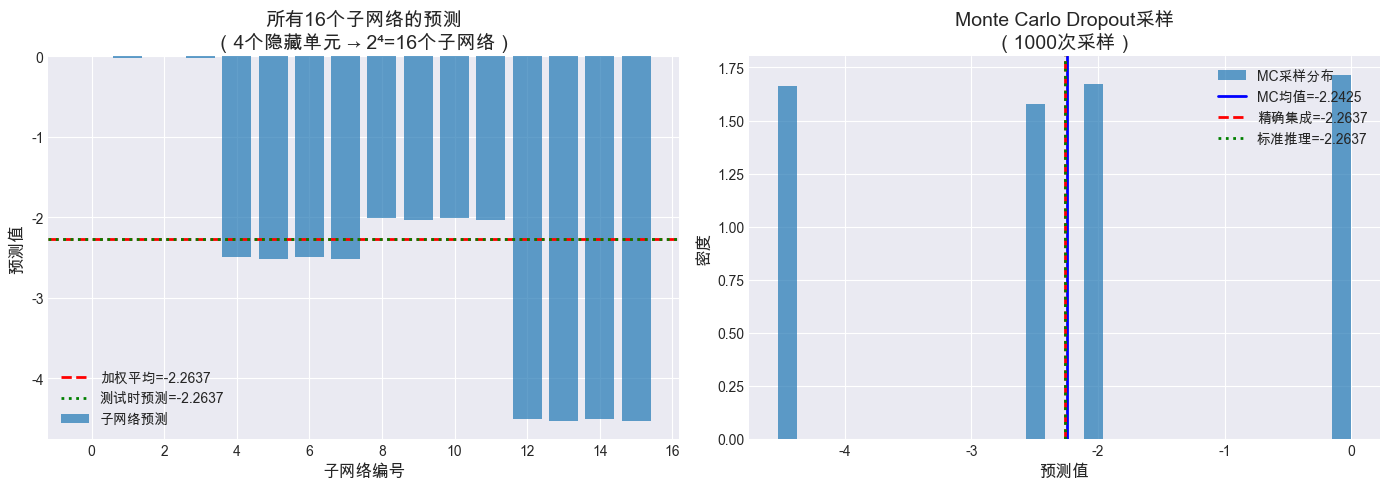


关键结论：
1. 精确集成预测（加权平均所有子网络）: -2.2637
2. 标准测试时预测（使用全部单元）: -2.2637
3. Monte Carlo Dropout均值: -2.2425

三者非常接近！说明：
- 测试时使用全部单元 ≈ 所有子网络的加权平均
- 这就是Dropout作为隐式集成的数学基础


In [6]:
class DropoutEnsembleDemo:
    """
    演示Dropout作为集成学习的效果
    
    关键概念:
        - Dropout训练时：每次前向传播使用不同的子网络
        - Dropout预测时：使用所有子网络的加权平均
        - 这等价于训练了2^n个子模型的集成（n为可dropout的单元数）
    """
    
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        """
        初始化简单的单隐藏层网络
        """
        self.dropout_rate = dropout_rate
        
        # 初始化权重（使用Xavier初始化）
        self.W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros(hidden_dim)
        self.W2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(2.0 / hidden_dim)
        self.b2 = np.zeros(output_dim)
        
        self.hidden_dim = hidden_dim
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def forward_with_mask(self, X, mask):
        """
        使用特定的dropout掩码进行前向传播
        
        参数:
            X: 输入数据
            mask: 二值掩码，指定哪些隐藏单元被激活
        
        返回:
            网络输出
        """
        # 隐藏层
        h = self.relu(X @ self.W1 + self.b1)
        # 应用dropout掩码
        h = h * mask
        # 输出层
        out = h @ self.W2 + self.b2
        return out
    
    def predict_dropout_train(self, X, n_samples=1):
        """
        训练时的dropout预测（随机掩码）
        """
        predictions = []
        for _ in range(n_samples):
            # 生成随机dropout掩码
            mask = np.random.binomial(1, 1 - self.dropout_rate, self.hidden_dim)
            # 训练时需要缩放
            mask = mask / (1 - self.dropout_rate)
            pred = self.forward_with_mask(X, mask)
            predictions.append(pred)
        return predictions
    
    def predict_dropout_test(self, X):
        """
        测试时的dropout预测（使用全部单元）
        """
        # 使用全部单元（掩码全为1，不需要缩放）
        mask = np.ones(self.hidden_dim)
        return self.forward_with_mask(X, mask)
    
    def enumerate_all_subnetworks(self, X):
        """
        枚举所有可能的子网络并计算预测
        
        注意：只对小型网络可行（2^n复杂度）
        
        返回:
            所有子网络的预测列表
        """
        n = self.hidden_dim
        all_predictions = []
        weights = []  # 每个子网络的权重
        
        # 枚举所有2^n种掩码
        for i in range(2**n):
            # 将整数i转换为二进制掩码
            mask = np.array([(i >> j) & 1 for j in range(n)])
            
            # 计算这个掩码出现的概率
            # P(mask) = p^(k) * (1-p)^(n-k)，其中k是激活的单元数
            k = np.sum(mask)
            p = 1 - self.dropout_rate
            prob = (p ** k) * ((1 - p) ** (n - k))
            weights.append(prob)
            
            # 需要缩放以匹配训练时的期望
            scaled_mask = mask / (1 - self.dropout_rate) if k > 0 else mask
            pred = self.forward_with_mask(X, scaled_mask)
            all_predictions.append(pred)
        
        return all_predictions, weights


def demonstrate_dropout_ensemble():
    """
    演示Dropout的集成效果
    """
    # 创建一个小型网络（隐藏层只有4个单元，可以枚举所有2^4=16个子网络）
    np.random.seed(42)
    net = DropoutEnsembleDemo(input_dim=2, hidden_dim=4, output_dim=1, dropout_rate=0.5)
    
    # 测试输入
    X = np.array([[1.0, 2.0]])
    
    # 方法1：枚举所有子网络
    all_preds, weights = net.enumerate_all_subnetworks(X)
    all_preds = np.array(all_preds).flatten()
    weights = np.array(weights)
    
    # 加权平均（真正的集成预测）
    ensemble_pred = np.sum(all_preds * weights)
    
    # 方法2：测试时使用全部单元
    test_pred = net.predict_dropout_test(X)[0, 0]
    
    # 方法3：Monte Carlo采样（模拟训练时的dropout）
    mc_preds = net.predict_dropout_train(X, n_samples=1000)
    mc_preds = np.array(mc_preds).flatten()
    mc_mean = np.mean(mc_preds)
    
    # 可视化
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 左图：所有子网络的预测分布
    ax1 = axes[0]
    ax1.bar(range(len(all_preds)), all_preds, alpha=0.7, label='子网络预测')
    ax1.axhline(y=ensemble_pred, color='red', linestyle='--', linewidth=2, 
                label=f'加权平均={ensemble_pred:.4f}')
    ax1.axhline(y=test_pred, color='green', linestyle=':', linewidth=2, 
                label=f'测试时预测={test_pred:.4f}')
    ax1.set_xlabel('子网络编号', fontsize=12)
    ax1.set_ylabel('预测值', fontsize=12)
    ax1.set_title(f'所有{len(all_preds)}个子网络的预测\n（4个隐藏单元 → 2⁴=16个子网络）', fontsize=14)
    ax1.legend()
    
    # 右图：Monte Carlo采样分布
    ax2 = axes[1]
    ax2.hist(mc_preds, bins=30, density=True, alpha=0.7, label='MC采样分布')
    ax2.axvline(x=mc_mean, color='blue', linestyle='-', linewidth=2, 
                label=f'MC均值={mc_mean:.4f}')
    ax2.axvline(x=ensemble_pred, color='red', linestyle='--', linewidth=2, 
                label=f'精确集成={ensemble_pred:.4f}')
    ax2.axvline(x=test_pred, color='green', linestyle=':', linewidth=2, 
                label=f'标准推理={test_pred:.4f}')
    ax2.set_xlabel('预测值', fontsize=12)
    ax2.set_ylabel('密度', fontsize=12)
    ax2.set_title('Monte Carlo Dropout采样\n（1000次采样）', fontsize=14)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\n关键结论：")
    print(f"1. 精确集成预测（加权平均所有子网络）: {ensemble_pred:.4f}")
    print(f"2. 标准测试时预测（使用全部单元）: {test_pred:.4f}")
    print(f"3. Monte Carlo Dropout均值: {mc_mean:.4f}")
    print(f"\n三者非常接近！说明：")
    print("- 测试时使用全部单元 ≈ 所有子网络的加权平均")
    print("- 这就是Dropout作为隐式集成的数学基础")

demonstrate_dropout_ensemble()

### 5.3 Dropout降低方差的原理

集成学习（如Bagging）可以有效降低方差。Dropout通过以下机制实现类似效果：

1. **多样性**：每个子网络看到不同的特征组合
2. **共享参数**：子网络之间共享权重，训练效率高
3. **近似平均**：测试时自动近似所有子网络的平均

Dropout降低方差的演示


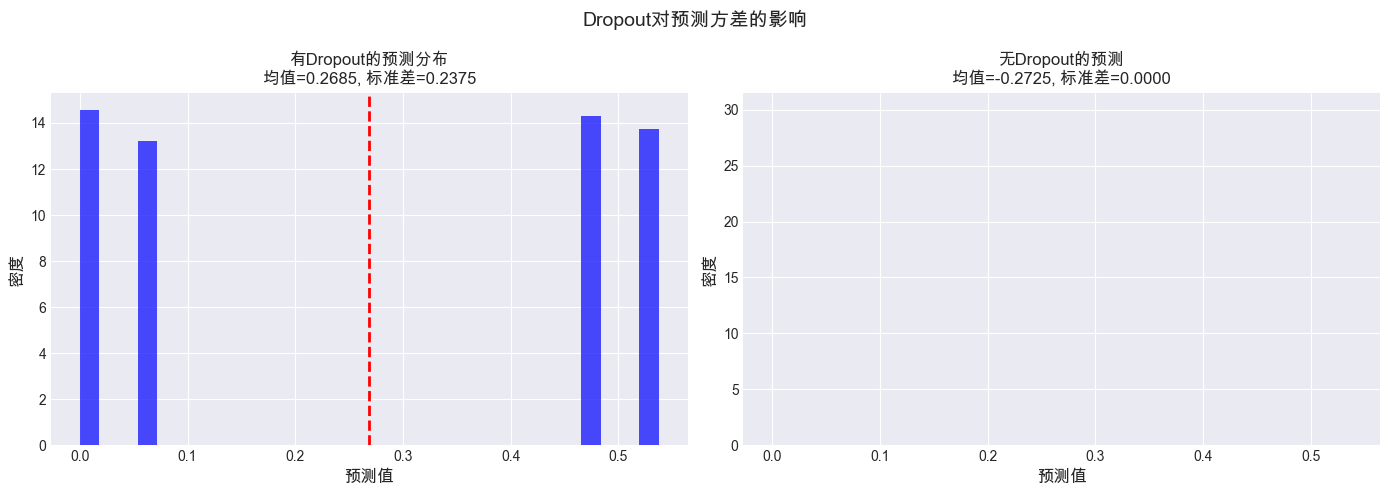


关键观察：
- 有Dropout时，每次预测使用不同的子网络，产生预测分布
- 无Dropout时，每次预测结果相同

Dropout的集成效应：
- 训练时：强迫不同子网络学习独立的特征
- 测试时：组合所有子网络的预测，方差更低


In [7]:
def demonstrate_dropout_variance_reduction():
    """
    演示Dropout如何降低方差
    
    实验设计:
        - 训练多个网络（有无Dropout）
        - 比较预测的方差
    """
    print("=" * 60)
    print("Dropout降低方差的演示")
    print("=" * 60)
    
    # 简化演示：使用单个点的多次预测
    np.random.seed(42)
    
    # 创建网络
    net_with_dropout = DropoutEnsembleDemo(
        input_dim=2, hidden_dim=10, output_dim=1, dropout_rate=0.5
    )
    net_without_dropout = DropoutEnsembleDemo(
        input_dim=2, hidden_dim=10, output_dim=1, dropout_rate=0.0
    )
    
    # 测试输入
    X = np.array([[1.0, 2.0]])
    
    # 有Dropout：多次采样
    preds_with_dropout = net_with_dropout.predict_dropout_train(X, n_samples=1000)
    preds_with_dropout = np.array(preds_with_dropout).flatten()
    
    # 无Dropout：每次预测相同
    preds_without_dropout = net_without_dropout.predict_dropout_test(X)
    preds_without_dropout = np.array([preds_without_dropout[0, 0]] * 1000)
    
    # 可视化
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1 = axes[0]
    ax1.hist(preds_with_dropout, bins=30, density=True, alpha=0.7, color='blue')
    ax1.axvline(x=np.mean(preds_with_dropout), color='red', linestyle='--', linewidth=2)
    ax1.set_xlabel('预测值', fontsize=12)
    ax1.set_ylabel('密度', fontsize=12)
    ax1.set_title(f'有Dropout的预测分布\n均值={np.mean(preds_with_dropout):.4f}, '
                  f'标准差={np.std(preds_with_dropout):.4f}', fontsize=12)
    
    ax2 = axes[1]
    ax2.hist(preds_without_dropout, bins=30, density=True, alpha=0.7, color='green')
    ax2.axvline(x=np.mean(preds_without_dropout), color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('预测值', fontsize=12)
    ax2.set_ylabel('密度', fontsize=12)
    ax2.set_title(f'无Dropout的预测\n均值={np.mean(preds_without_dropout):.4f}, '
                  f'标准差={np.std(preds_without_dropout):.4f}', fontsize=12)
    ax2.set_xlim(ax1.get_xlim())  # 使用相同的x轴范围
    
    plt.suptitle('Dropout对预测方差的影响', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("\n关键观察：")
    print("- 有Dropout时，每次预测使用不同的子网络，产生预测分布")
    print("- 无Dropout时，每次预测结果相同")
    print("\nDropout的集成效应：")
    print("- 训练时：强迫不同子网络学习独立的特征")
    print("- 测试时：组合所有子网络的预测，方差更低")

demonstrate_dropout_variance_reduction()

---

## 6. 总结与要点

### 6.1 偏差-方差分解要点

$$\text{总误差} = \text{Bias}^2 + \text{Variance} + \text{不可约误差}$$

| 误差来源 | 含义 | 如何减少 |
|---------|------|----------|
| Bias² | 模型的系统性偏差 | 增加复杂度、添加特征 |
| Variance | 对训练数据的敏感度 | 增加数据、正则化、集成 |
| 不可约误差 | 数据本身的噪声 | 无法减少 |

### 6.2 偏差-方差权衡的实践意义

1. **诊断模型问题**：
   - 训练误差高，测试误差高 → 高偏差（欠拟合）
   - 训练误差低，测试误差高 → 高方差（过拟合）

2. **选择模型复杂度**：
   - 使用交叉验证找到最优复杂度
   - 在偏差和方差之间寻找平衡

3. **改进模型**：
   - 识别瓶颈（偏差还是方差）
   - 针对性地采取措施

---

## 7. 练习题

### 练习1：手动计算偏差-方差分解

假设真实函数 $f(x) = 2x + 1$，噪声 $\sigma^2 = 0.1$。
你训练了一个模型，在测试点 $x=1$ 上的多次预测为：[3.2, 2.8, 3.1, 2.9, 3.0]。

计算该模型在 $x=1$ 处的：
1. 偏差
2. 方差
3. 总期望误差

### 练习2：学习曲线分析

绘制学习曲线（训练误差和验证误差随训练数据量的变化），分析：
1. 什么情况下模型是高偏差？
2. 什么情况下模型是高方差？
3. 如何从学习曲线判断应该增加数据还是增加模型复杂度？

### 练习3（挑战）：实验验证Dropout的集成效果

训练一个带Dropout的神经网络，比较：
1. 标准测试（使用缩放后的全部权重）
2. Monte Carlo Dropout（采样多个子网络并平均）

两种方法的预测是否一致？

In [ ]:
# 练习答案区域

def exercise_1():
    """
    练习1: 手动计算偏差-方差分解
    """
    # 真实值
    f_true = 2 * 1 + 1  # f(1) = 3
    
    # 预测值
    predictions = np.array([3.2, 2.8, 3.1, 2.9, 3.0])
    
    # 计算偏差
    mean_pred = np.mean(predictions)
    bias = mean_pred - f_true
    bias_squared = bias ** 2
    
    # 计算方差
    variance = np.var(predictions)
    
    # 噪声
    noise_squared = 0.1
    
    # 总期望误差
    total_error = bias_squared + variance + noise_squared
    
    print("练习1答案：")
    print(f"真实值 f(1) = {f_true}")
    print(f"预测均值 E[f̂(1)] = {mean_pred}")
    print(f"偏差 Bias = {bias:.4f}")
    print(f"偏差² Bias² = {bias_squared:.4f}")
    print(f"方差 Variance = {variance:.4f}")
    print(f"噪声² σ² = {noise_squared}")
    print(f"总期望误差 = {total_error:.4f}")

exercise_1()

---

## 参考资料

1. **偏差-方差分解**: Hastie et al., "The Elements of Statistical Learning" Chapter 7
2. **Dropout**: Srivastava et al., "Dropout: A Simple Way to Prevent Neural Networks from Overfitting" (JMLR 2014)
3. **集成学习视角**: Gal & Ghahramani, "Dropout as a Bayesian Approximation" (ICML 2016)

---

**下一章预告**: 03b_activation_advanced.ipynb - 新型激活函数与万能近似定理